# Making colour images from data layers
Gilles Ferrand<br>
2020-01-16<br>
2021-05-22

This notebook shows how to make colour images by combining data layers, using either RGB channels or arbitrary blending.<br>
Note that we do not consider here the preliminary steps of image registration and data stretching (we will only allow for a linear weight), nor the final steps of global adjustments, cosmetic edits, and cropping.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plt_show(array,ax=None,cmap='gray',vmin=None,vmax=None,title="",fname=""):
    if ax==None: ax=plt.gca()
    ax.imshow(array,origin='lower',aspect='equal',cmap=cmap,vmin=vmin,vmax=vmax)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    if title!="": ax.set_title(title)
    if fname!="": plt.imsave(arr=array,fname=fname+".png",origin='lower',cmap=cmap)

In [3]:
def show_layers(layers, size=2):
    fig, ax = plt.subplots(1,len(layers), figsize=(len(layers)*size,size))
    if len(layers)==1: 
        plt_show(layers[0],ax)
    else:
        for i in range(len(layers)): plt_show(layers[i],ax[i])

## mock data (V2)

fabricated with random Gaussian clumps

In [4]:
import mock
reload(mock)

<module 'mock' from 'mock.pyc'>

In [5]:
nx = 256
ny = 256

In [6]:
np.random.seed(42)

layers = []
data_diff = mock.Gaussian_clumps(nx=nx, ny=ny, n_clumps=1, sigma=[0.50], amp=[0.1], x=[0.5], y=[0.5], delta=0.2)
for j in range(6):
    data = mock.Gaussian_clumps(nx=nx, ny=ny, n_clumps=10, sigma=[0.15], amp=[0.1], x=[0.5], y=[0.5], delta=0.3)
    data += data_diff
    data /= data.max()
    layers.append(data)
    print j, data.min(), data.max()

0 0.014263719237190444 1.0
1 0.014084436807117622 1.0
2 0.01485591752520011 1.0
3 0.01233105311857431 1.0
4 0.013993018299612426 1.0
5 0.007071744683466287 1.0


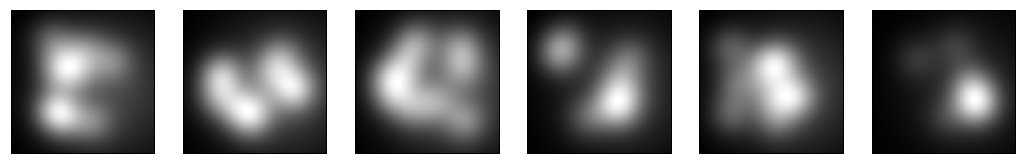

In [7]:
fig, ax = plt.subplots(1,len(layers),figsize=(len(layers)*3,3))
for j in range(len(layers)):
    plt_show(layers[j],ax[j],fname="layer_%i"%(j))

In [8]:
import combine
reload(combine)

<module 'combine' from 'combine.pyc'>

## The basic way: RGB channels

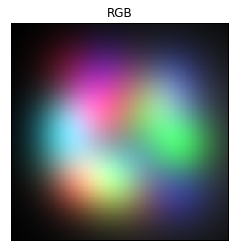

In [9]:
image = combine.RGB(layers[0:3])
plt_show(image,title="RGB", fname="data2 - RGB")

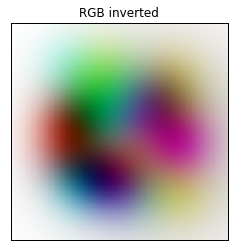

In [10]:
# inverted
for i in range(3): image[:,:,i] = 1-image[:,:,i]
plt_show(image, title="RGB inverted", fname="data2 - RGB inverted")

## The advanced way: blending layers

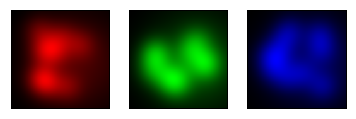

In [11]:
# the same 3 primaries R,G,B
R = [1, 0, 0]
G = [0, 1, 0]
B = [0, 0, 1]
colourized_layers = combine.colourize_RGB_list(layers[0:3], R, G, B)

show_layers(colourized_layers)

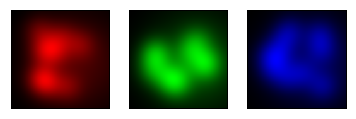

In [12]:
# the same 3 primaries R,G,B
H = [0, 120, 240]
S = [100]
V = [100]
colourized_layers = combine.colourize_HSV_list(layers[0:3], H, S, V)

show_layers(colourized_layers)

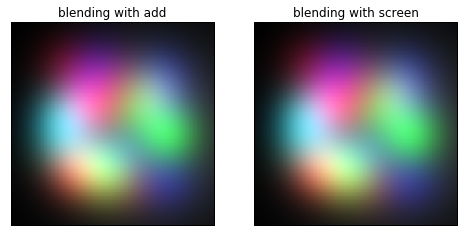

In [13]:
image_add = combine.blend(colourized_layers, combine.Add)
image_scr = combine.blend(colourized_layers, combine.Screen)

fig, ax = plt.subplots(1,2, figsize=(8,4))
plt_show(image_add,ax[0], title="blending with add"   , fname="data2 - blend add - 3 primaries")
plt_show(image_scr,ax[1], title="blending with screen", fname="data2 - blend screen - 3 primaries")

Blending 3 layers each colourized with one of the R,G,B primaries is the same as RGB compositing (with either *add* or *screen*).

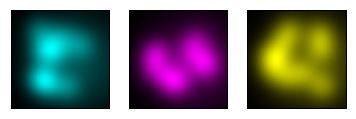

In [14]:
# the 3 secondaries C,M,Y
R = [0, 1, 1]
G = [1, 0, 1]
B = [1, 1, 0]
colourized_layers = combine.colourize_RGB_list(layers[0:3], R, G, B)

show_layers(colourized_layers)

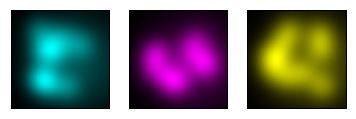

In [15]:
# the 3 secondaries C,M,Y
H = [180, 300, 60]
S = [100]
V = [100]
colourized_layers = combine.colourize_HSV_list(layers[0:3], H, S, V)

show_layers(colourized_layers)

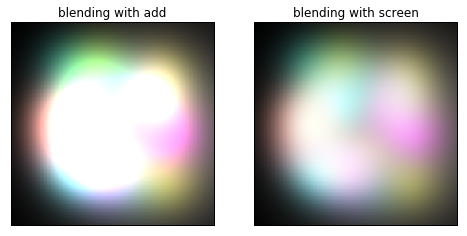

In [16]:
image_add = combine.blend(colourized_layers, combine.Add)
image_scr = combine.blend(colourized_layers, combine.Screen)

fig, ax = plt.subplots(1,2, figsize=(8,4))
plt_show(image_add,ax[0], title="blending with add"   , fname="data2 - blend add - 3 secondaries")
plt_show(image_scr,ax[1], title="blending with screen", fname="data2 - blend screen - 3 secondaries")

Compared with previous:<br>
\- Hues are inverted (but different from RGB invert above: background stays black).<br>
\- Colours are lighter. Since each colourized layer has 2 non-zero channels, blending them goes to white quicker?

Note that *add* quickly saturates, whereas *screen* never does. With *add* one needs to adjust the intensity levels accordingly before blending the layers.

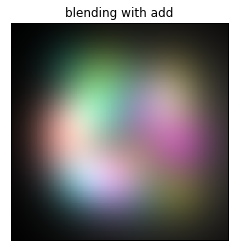

In [17]:
colourized_layers = combine.colourize_HSV_list(layers[0:3], H, S, [50])
image_add = combine.blend(colourized_layers, combine.Add)

fig, ax = plt.subplots(1,1, figsize=(4,4))
plt_show(image_add,ax, title="blending with add")

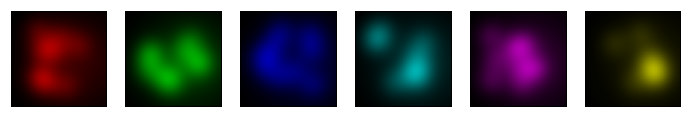

In [18]:
# the 6 layers, with the 3 primaries + 3 secondaries
w = 0.7
R = [w, 0, 0, 0, w, w]
G = [0, w, 0, w, 0, w]
B = [0, 0, w, w, w, 0]
colourized_layers = combine.colourize_RGB_list(layers[0:6], R, G, B)

show_layers(colourized_layers)

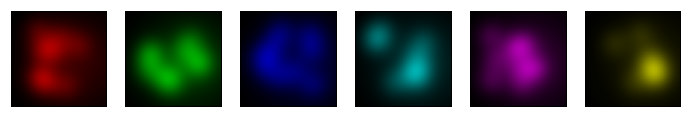

In [19]:
# the 6 layers, with the 3 primaries + 3 secondaries
H = [0, 120, 240, 180, 300, 60]
S = [100]
V = [70]
colourized_layers = combine.colourize_HSV_list(layers[0:6], H, S, V)

show_layers(colourized_layers)

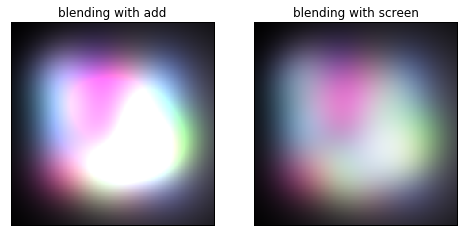

In [20]:
image_add = combine.blend(colourized_layers, combine.Add)
image_scr = combine.blend(colourized_layers, combine.Screen)

fig, ax = plt.subplots(1,2, figsize=(8,4))
plt_show(image_add,ax[0], title="blending with add"   , fname="data2 - blend add - 6 prim and sec")
plt_show(image_scr,ax[1], title="blending with screen", fname="data2 - blend screen - 6 prim and sec")

Colours are getting more complicated to interpret.

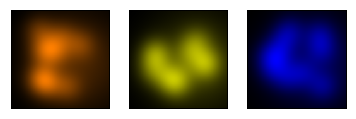

In [21]:
# 3 layers arbitrarily colourized
R = [1  , 0.8, 0]
G = [0.5, 0.8, 0]
B = [0  , 0  , 1]
colourized_layers = combine.colourize_RGB_list(layers[0:3], R, G, B)

show_layers(colourized_layers)

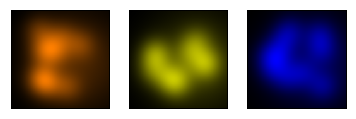

In [22]:
# 3 layers arbitrarily colourized
H = [30, 60, 240]
S = [100]
V = [100, 80, 100]
colourized_layers = combine.colourize_HSV_list(layers[0:3], H, S, V)

show_layers(colourized_layers)

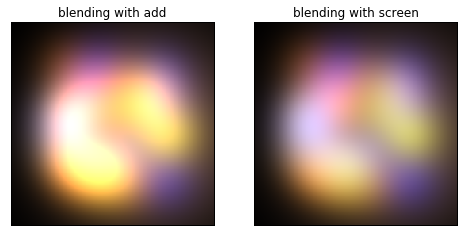

In [23]:
image_add = combine.blend(colourized_layers, combine.Add)
image_scr = combine.blend(colourized_layers, combine.Screen)

fig, ax = plt.subplots(1,2, figsize=(8,4))
plt_show(image_add,ax[0], title="blending with add"   , fname="data2 - blend add - 3")
plt_show(image_scr,ax[1], title="blending with screen", fname="data2 - blend screen - 3")

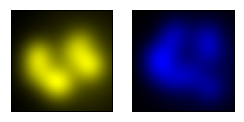

In [24]:
# 2 layers with complement hues
R = [1, 0]
G = [1, 0]
B = [0, 1]
colourized_layers = combine.colourize_RGB_list(layers[1:3], R, G, B)

show_layers(colourized_layers)

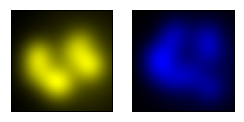

In [25]:
# 2 layers with complement hues
H = [60, 60+180]
S = [100]
V = [100]
colourized_layers = combine.colourize_HSV_list(layers[1:3], H, S, V)

show_layers(colourized_layers)

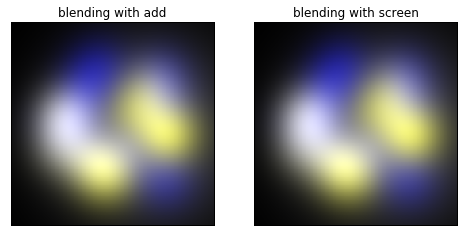

In [26]:
image_add = combine.blend(colourized_layers, combine.Add)
image_scr = combine.blend(colourized_layers, combine.Screen)

fig, ax = plt.subplots(1,2, figsize=(8,4))
plt_show(image_add,ax[0], title="blending with add"   , fname="data2 - blend add - 2 comp")
plt_show(image_scr,ax[1], title="blending with screen", fname="data2 - blend screen - 2 comp")

The complementaries add up to white, the effect is the same for *add* and *screen*.

___

## mock data (V1)

In [27]:
np.random.seed(42)

layers = []
for j in range(6):
    print "realization #",j
    layers.append([np.zeros((nx,ny))])
    for i in np.linspace(0,2,6):
        clumps = mock.Gaussian_clumps(nx=nx, ny=ny, n_clumps=int(10**i), sigma=[10**(-i)])
        layers[j].append(clumps)
        layers[j][0] += clumps

realization # 0
realization # 1
realization # 2
realization # 3
realization # 4
realization # 5


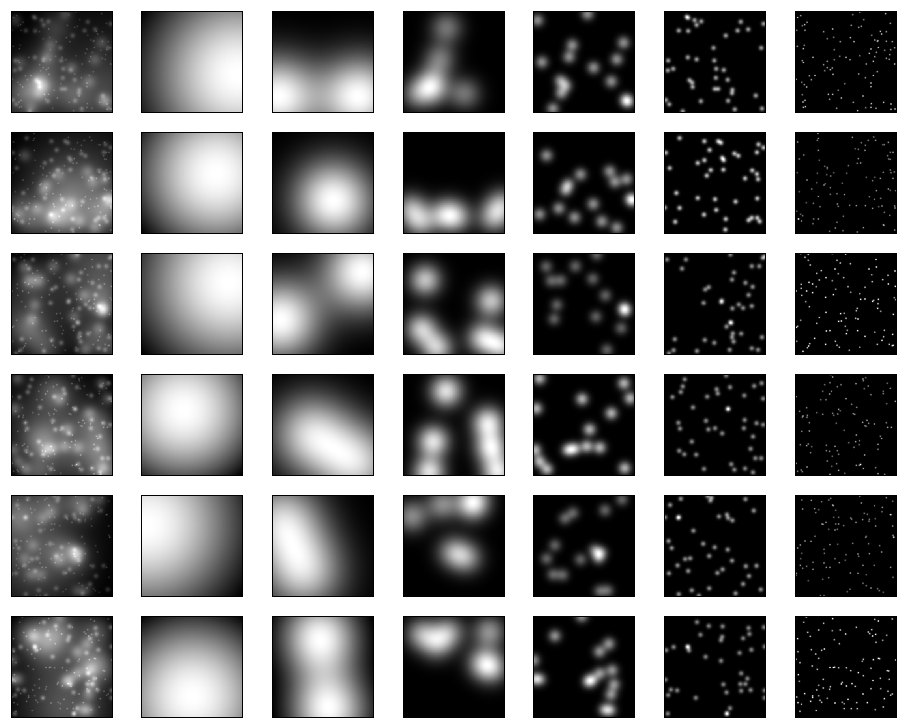

In [28]:
fig, ax = plt.subplots(len(layers),len(layers[0]), figsize=(16,16*len(layers)/len(layers[0])))
for j in range(len(layers)):
    for i in range(len(layers[j])): 
        plt_show(layers[j][i],ax[j,i],fname="layer_%i_%i"%(j,i))

Each row is an independent, random realization.<br>
Columns show clumps at different scales, the first one being the sum.

In [29]:
import combine
reload(combine)

<module 'combine' from 'combine.pyc'>

## The basic way: RGB channels

This technique is straightforward, but works with only exactly 3 layers, and hue choices are restricted to the 3 RGB primaries.

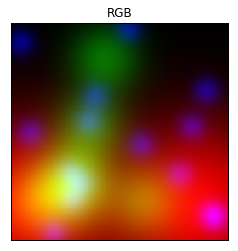

In [30]:
# first set, 3 scales
image = combine.RGB(layers[0][2:5])
plt_show(image, title="RGB", fname="data1 - RGB - first set 3 scales")

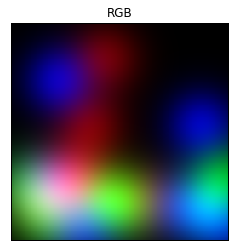

In [31]:
# medium scale, 3 sets
image = combine.RGB(zip(*layers)[3][:3])
plt_show(image, title="RGB", fname="data1 - RGB - medium scale, 3 sets")

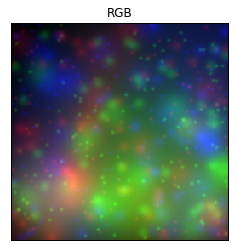

In [32]:
# all scales, 3 sets
image = combine.RGB(zip(*layers)[0][:3])
plt_show(image, title="RGB", fname="data1 - RGB - all scales, 3 sets")

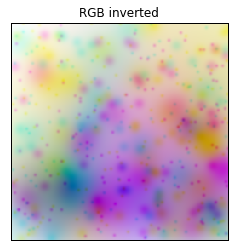

In [33]:
# inverted (not the same as blending the secondary colours)
for i in range(3): image[:,:,i] = 1-image[:,:,i]
plt_show(image, title="RGB inverted", fname="data1 - RGB - all scales, 3 sets, inverted")

## The advanced way: blending layers

This techniques works with any number of layers, and allows one to select any hue per layer. <br>It requires defining a blending mode, the optimal mode being known as "screen".

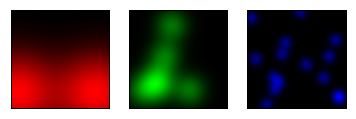

In [34]:
# first set, 3 scales
H = [0, 120, 240]
S = [100]
V = [100]
colourized_layers = combine.colourize_HSV_list(layers[0][2:5], H, S, V)

show_layers(colourized_layers)

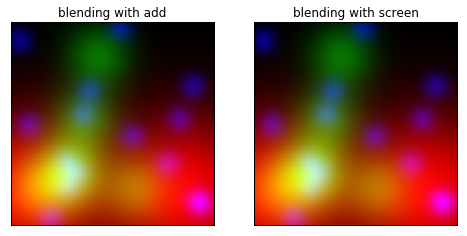

In [35]:
image_add = combine.blend(colourized_layers, combine.Add)
image_scr = combine.blend(colourized_layers, combine.Screen)

fig, ax = plt.subplots(1,2, figsize=(8,4))
plt_show(image_add,ax[0], title="blending with add"   , fname="data1 - blend add - first set, 3 scales")
plt_show(image_scr,ax[1], title="blending with screen", fname="data1 - blend screen - first set, 3 scales")

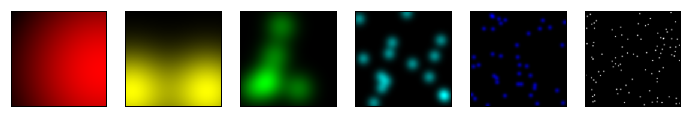

In [36]:
# first set, 6 scales
H = [0, 60, 120, 180, 240, 300]
S = [100]*6
S[-1] = 0 # neutral "stars"
V = [100]
#V[0] = 50 # darker bkg "cloud"
colourized_layers = combine.colourize_HSV_list(layers[0][1:7], H, S, V)

show_layers(colourized_layers)

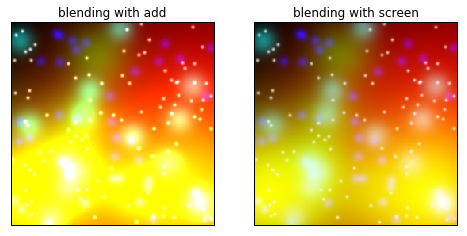

In [37]:
image_add = combine.blend(colourized_layers, combine.Add)
image_scr = combine.blend(colourized_layers, combine.Screen)

fig, ax = plt.subplots(1,2, figsize=(8,4))
plt_show(image_add,ax[0], title="blending with add"   , fname="data1 - blend add - first set, 6 scales")
plt_show(image_scr,ax[1], title="blending with screen", fname="data1 - blend screen - first set, 6 scales")

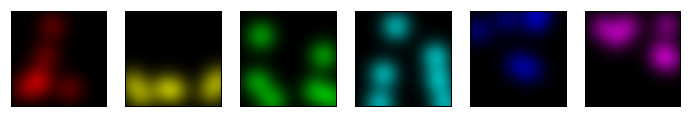

In [38]:
# medium scale, 6 sets
H = [0, 60, 120, 180, 240, 300]
S = [100]
V = [70]
colourized_layers = combine.colourize_HSV_list(zip(*layers)[3][0:6], H, S, V)

show_layers(colourized_layers)

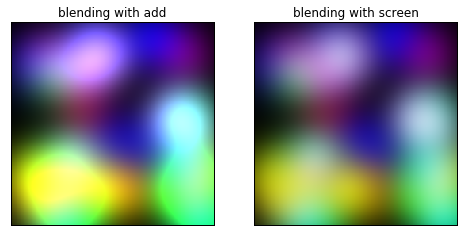

In [39]:
image_add = combine.blend(colourized_layers, combine.Add)
image_scr = combine.blend(colourized_layers, combine.Screen)

fig, ax = plt.subplots(1,2, figsize=(8,4))
plt_show(image_add,ax[0], title="blending with add"   , fname="data1 - blend add - medium scale, 6 sets")
plt_show(image_scr,ax[1], title="blending with screen", fname="data1 - blend screen - medium scale, 6 sets")

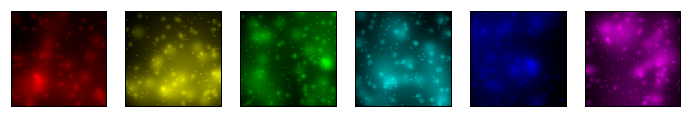

In [40]:
# all scales, 6 sets
H = [0, 60, 120, 180, 240, 300]
S = [100]*len(H)
V = [100]*len(H)
colourized_layers = combine.colourize_HSV_list(zip(*layers)[0][0:6], H, S, V)

show_layers(colourized_layers)

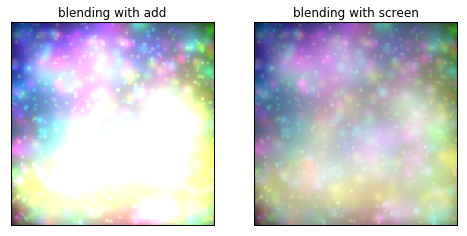

In [41]:
image_add = combine.blend(colourized_layers, combine.Add)
image_scr = combine.blend(colourized_layers, combine.Screen)

fig, ax = plt.subplots(1,2, figsize=(8,4))
plt_show(image_add,ax[0], title="blending with add"   , fname="data1 - blend add - all scales, 6 sets")
plt_show(image_scr,ax[1], title="blending with screen", fname="data1 - blend screen - all scales, 6 sets")

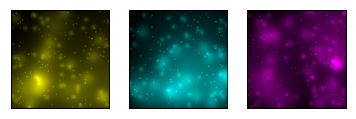

In [42]:
# all scales, 3 sets
H = [60, 180, 300]
S = [100]*len(H)
V = [100]*len(H)
colourized_layers = combine.colourize_HSV_list(zip(*layers)[0][0:3], H, S, V)

show_layers(colourized_layers)

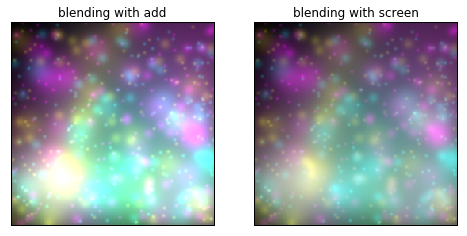

In [43]:
image_add = combine.blend(colourized_layers, combine.Add)
image_scr = combine.blend(colourized_layers, combine.Screen)

fig, ax = plt.subplots(1,2, figsize=(8,4))
plt_show(image_add,ax[0], title="blending with add"   , fname="data1 - blend add - all scales, 3 sets")
plt_show(image_scr,ax[1], title="blending with screen", fname="data1 - blend screen - all scales, 3 sets")